### Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import pandas as pd
import seaborn as sns
import os

from functools import reduce
from tqdm import tqdm, tqdm_pandas
# from tqdm._tqdm_notebook import tqdm_notebook

In [3]:
tqdm.pandas()

### Constant

In [4]:
base_path = '../dataset/database_local'
# base_path = '../dataset/database'

In [5]:
flight_runway_file = base_path + '/04_flights_with_runway.csv'
landing_runway_file = base_path + '/04_landing_count_detail.csv'
all_fdm_file = base_path + '/06_all_crucial_fdm.csv'
output_flap_file = base_path + '/07_param_flap.csv'

# Read Data

#### 1. Read All Crucial FDM Flight

In [6]:
all_fdm = pd.read_csv(all_fdm_file, index_col=0)
display(all_fdm.head())
print(all_fdm.shape)

,hbaro_m,hdot_1_mps,flap_te_pos,gs_dev_ddm,gs_mps,loc_dev_ddm,lg_squat_mr,n11_rpm,n12_rpm,n13_rpm,n14_rpm,theta_rad,hralt_m,tas_mps,chi_rad,file
56812,999.1344,-8.37184,NaN,NaN,120.76479,NaN,NaN,33.78125,32.9375,32.6875,33.40625,0.016490,838.200,105.492352,2.156426,686200104130429.csv
56813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,686200104130429.csv
56814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017640,835.152,NaN,NaN,686200104130429.csv
56815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,686200104130429.csv
56816,996.6960,-9.42848,79.0,-0.10569,120.76479,-0.276164,0.0,33.78125,32.9375,32.6875,33.40625,0.018982,838.200,105.878182,2.168218,686200104130429.csv


(800, 16)


In [9]:
test = all_fdm[['flap_te_pos']].dropna() / 100
test['flap_te_pos_flag'] = test['flap_te_pos'].map(lambda x: 0 if x >= 30 else 1)
test.head()

,flap_te_pos,flap_te_pos_flag
56816,0.79,1
56832,0.78,1
56848,0.79,1
56864,0.79,1
56880,0.79,1


# Transform Data

### Parameter Function
Determine if a flight is unstable or stable. Steps:
1. Convert `flap_te_pos` to degrees by dividing with 100
2. Unstable condition: `flap_te_pos < 30` for 5s consecutive
    - Search for value < 30, if the next 5 consecutive is still < 30 then unstable, else stable.

In [10]:
list_a = [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]

def find_n_consecutive_flag(flag_list: list, n: int) -> bool:
    if len(flag_list) < n:
        return(False)
    for i in range(len(flag_list) - (n - 1)):
        if list_a[i] == 0:
            continue
        sum_flag = sum(flag_list[i:i+n])
        if sum_flag == n:
            return(True)
    return(False)

find_n_consecutive_flag(list_a, 5)

True

In [19]:
def detect_flap_unstable(df):
    cleaned_flaps = df.flap_te_pos.dropna()
    flap_deg = cleaned_flaps / 100
    sns.lineplot(data=flap_deg.reset_index(drop=True), lw=0.25, color='#1f77b4')
    flap_flag = list(flap_deg < 30)
    is_unstable = find_n_consecutive_flag(flap_flag, n=5)
    return int(is_unstable)

##### Test Function on DF 

In [12]:
stable_file = '687200109140645.csv'
unstable_file = '687200312291858.csv'

1. Stable FDM

<AxesSubplot:>

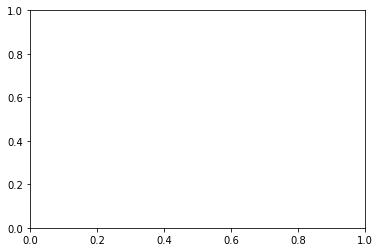

In [13]:
stable_fdm = all_fdm[all_fdm['file'] == stable_file]
sns.lineplot(data=stable_fdm.flap_te_pos/100)

False

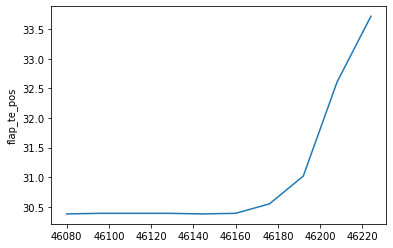

In [215]:
detect_flap_unstable(stable_fdm)

5. Unstable FDM

<AxesSubplot:ylabel='flap_te_pos'>

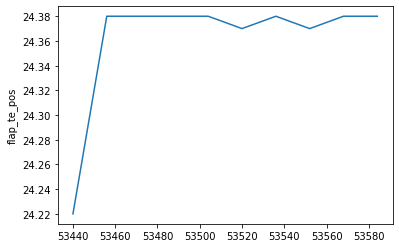

In [198]:
unstable_fdm = all_fdm[all_fdm['file'] == unstable_file]
sns.lineplot(data=unstable_fdm.flap_te_pos/100)

In [199]:
detect_flap_unstable(unstable_fdm)

True

### Detect for All FDM

100%|██████████| 5/5 [00:00<00:00, 47.97it/s]


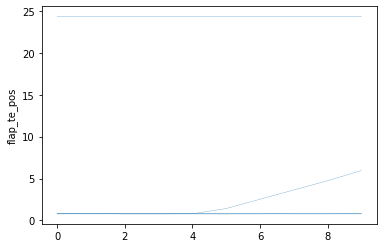

In [20]:
unstable_detection = all_fdm.groupby('file').progress_apply(detect_flap_unstable)

In [21]:
print(f"{sum(unstable_detection)}/{len(unstable_detection)}")

5/5


In [22]:
unstable_detection

file
686200104121245.csv    1
686200104121532.csv    1
686200104121825.csv    1
686200104130429.csv    1
686200104130652.csv    1
dtype: int64

In [23]:
unstable_detection_df = pd.DataFrame(unstable_detection, columns=['flap'])
unstable_detection_df.head()

,flap
file,
686200104121245.csv,1
686200104121532.csv,1
686200104121825.csv,1
686200104130429.csv,1
686200104130652.csv,1


In [24]:
unstable_detection_df.to_csv(output_flap_file)